In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
import winsound
import dill
import datetime as dt
import data_load as dl
graph_data=dl.graph_data

Notebook
GPU detected
Not notebook


In [2]:
model=tf.keras.models.load_model('from_config/trained_models/IceCube/Sage_sage1nonorm_10_2aauycmh')
model.compile()

In [15]:
batch_size=512
dataset=graph_data(n_data=100000,skip=int(1.4e6-1), restart=1, transform=True, angle=True, unitvec=False)

# print(len(dataset_test))
# winsound.Beep(400,300)

Removed and ready to reload
Connecting to db-file
Loading Muons
Reading files


C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Splitting data to events


  0%|▏                                                                          | 235/100000 [00:00<01:30, 1106.32it/s]

     dom_x    dom_y    dom_z      time  charge_log10  SRTInIcePulses
0  0.11439 -0.46199 -0.14812  1.622453     -0.621035               0
1  0.13203  0.20298  0.12828 -0.060393     -1.921554               1
2  0.13203  0.20298  0.11126 -0.000741     -1.656923               1
3  0.38235  0.23890 -0.38653 -0.212301     -0.280277               0
4  0.50527  0.25788 -0.37884 -1.727306      0.162615               0
   energy_log10    zenith   azimuth
0      2.437721  0.661937  1.697274
1      2.584876  0.205041  4.291144
2      2.476674  0.661661  1.374715
3      2.409273  0.390813  2.876407
4      2.356129  0.889406  2.381056
Generating adjacency matrices


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:12<00:00, 1386.52it/s]


Saving dataset
Loading data to memory


In [28]:
loader_test = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [17]:
def loss_func(y_reco, y_true, re=False):
    loss_energy = tf.reduce_mean(abs(tf.subtract(y_reco[:,0], y_true[:,0])))
    kappa=tf.math.abs(y_reco[:,3])
#     tf.print(tf.reduce_mean(kappa))
    azp = y_reco[:,2] #Azimuth prediction
    azt = y_true[:,2] #Azimuth target
    zep = y_reco[:,1] #Zenith prediction
    zet = y_true[:,1] #Zenith target
    s1 = tf.math.sin(zet + azt - azp )
    s2 = tf.math.sin( zet - azt + azp )
    c1 = tf.math.cos( zet - zep )
    c2 = tf.math.cos( zet + zep )
    cos_angle = 0.5*tf.math.abs(tf.math.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2)
    nlogC = - tf.math.log(kappa) + kappa + tf.math.log( 1 - tf.math.exp( - 2 * kappa) )

    loss_angle = tf.reduce_mean( - kappa*cos_angle + nlogC )
    if not re:
        return loss_angle+loss_energy
    if re:
        return float(loss_angle+loss_energy), [float(loss_energy), float(loss_angle)]

In [18]:
def metrics_angle(y_reco, y_true):
    w_energy = tfp.stats.percentile(tf.math.abs(tf.subtract(y_true[:, 0], y_reco[:, 0])), [50-34, 50, 50+34]) 
#     w_energy         = (energy_quantiles[1] - energy_quantiles[0]) / 1.349
    
    alpha= tf.math.acos(tf.math.sin(y_reco[:, 1])*tf.math.sin(y_true[:, 1])*tf.math.cos(tf.subtract(y_reco[:, 2],y_true[:, 2]))+tf.math.cos(y_reco[:, 1])*tf.math.cos(y_true[:, 1]))
    # tf.print(alpha)
    angle_resi = 180 / np.pi * alpha #degrees
    u_angle         = tfp.stats.percentile(angle_resi, [50-34,50,50+34])

    return w_energy.numpy(), u_angle.numpy()

metrics=metrics_angle


In [29]:
@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 

    return predictions, targets

def performance_e_alpha(loader, plot=True):
    '''Function to test and plot performance of Graph DL
    input should be dom pos x,y,z , time, charge(log10)
    target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
    '''
    loss = 0
    prediction_list, target_list = [], []
    for batch in tqdm(loader):
        inputs, targets = batch
        predictions, targets = test_step(inputs, targets)
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()

    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []
    e_sig, alpha_sig = [], [] 
    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_reco[idx, :], y_true[idx, :])

        w_energies.append(w[1])
        u_angles.append(u_angle[1])
        e_sig.append([w[0], w[2]])
        alpha_sig.append([u_angle[0], u_angle[2]])
    if plot:
        fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))

        for a in ax:
            a_ = a.twinx()
            a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
            a_.set_yscale("log")
            a.set_xlabel("Log Energy")
        
        ax_top = ax

        # Energy reconstruction
        ax_top[0].errorbar(xs, w_energies,yerr=np.array(e_sig).T, fmt='k.',capsize=2,linewidth=1,ecolor='r',label='data')
        ax_top[0].set_title("Energy Performance")
        ax_top[0].set_ylabel(r"$\Delta log(E)$")

        # Angle reconstruction
        ax_top[1].errorbar(xs, u_angles,yerr=np.array(alpha_sig).T, fmt='k.',capsize=2,linewidth=1,ecolor='r',label='data')
        ax_top[1].set_title("Angle Performance")
        ax_top[1].set_ylabel(r"$\Delta \Omega$")

        return fig, ax

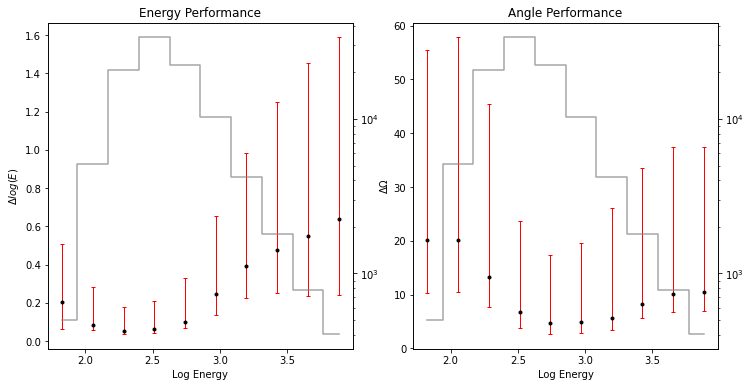

In [30]:
fig, ax = performance_e_alpha(loader_test)

In [63]:
loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

prediction_list, target_list = [], []
for batch in loader:
    inputs, targets = batch
    predictions, targets, out = test_step(inputs, targets)

    prediction_list.append(predictions.numpy())
    target_list.append(targets.numpy())
pred, true=np.array(prediction_list), np.array(target_list)
c='start'
for p in pred:
    if type(c)==str:
        c=p
    else:
        c=np.vstack((c,p))

pred=c
c='start'
for p in true:
    if type(c)==str:
        c=p
    else:
        c=np.vstack((c,p))
true=c

<ipython-input-63-80413c393d6b>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pred, true=np.array(prediction_list), np.array(target_list)


In [76]:
maskzen=pred[:,3]>np.mean(pred[:,3])

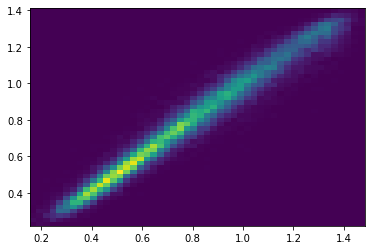

In [77]:
plt.hist2d(true[:,1][maskzen],pred[:,1][maskzen], bins=50);

In [237]:
loader = DisjointLoader(dataset, batch_size=1, epochs=1)
for i, batch in enumerate(loader):
    if i!=0:
        break
    else:
        X,Y=batch
def f(X):
    return model([X[:,i] for i in range(X.shape[1])]).flatten()

In [206]:
def wrap(data):
    X,Y=data[0], data[1]
    pred=np.array(predict(X,Y))
    c='start'
    for p in pred:
        if type(c)==str:
            c=p
        else:
            c=np.vstack((c,p))
    return c

@tf.function(input_signature = loader.tf_signature(), experimental_relax_shapes = True)
def predict(X,Y):
    pred = model(X)
    return pred

wrap([X,Y])

array([[2.2858586e+00, 8.7564194e-01, 1.4118334e+00, 3.5069420e+00,
        2.8451700e+01],
       [2.6735671e+00, 7.0045906e-01, 1.2953039e+00, 1.1683338e+02,
        5.6951715e+02],
       [2.5628908e+00, 3.3952430e-01, 1.8762739e+00, 1.9079247e+01,
        2.1348485e+02],
       [3.0431426e+00, 3.5632506e-01, 1.9580299e+00, 2.0733351e+01,
        1.5503844e+02],
       [2.3856163e+00, 1.1657273e+00, 1.1564362e+00, 6.0972668e+01,
        1.0032231e+02],
       [2.5753064e+00, 1.1205094e+00, 3.5434253e+00, 9.3913597e+01,
        1.7786584e+02],
       [2.6996746e+00, 2.1114388e-01, 3.4371817e+00, 1.2705321e+01,
        4.1107410e+02],
       [2.1781392e+00, 1.1001470e+00, 2.3805346e+00, 4.9331999e+00,
        3.7613815e+01],
       [2.3797405e+00, 1.0322312e+00, 3.0341485e+00, 5.3053002e+00,
        3.7415470e+01],
       [2.7637661e+00, 5.0368047e-01, 2.3872874e+00, 4.9672779e+01,
        2.7815973e+02]], dtype=float32)

In [247]:
# Define grad tracking function function
@tf.function(input_signature = loader.tf_signature(), experimental_relax_shapes = True)
def gradient_importance(inputs, targets):
#     features=tf.Variable(0)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
    grads = tape.gradient(predictions,  inputs)
#     grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    tf.print(grads)
    return grads

In [248]:
gradient_importance(X,Y)

AttributeError: in user code:

    <ipython-input-247-9bd6ec8c8563>:8 gradient_importance  *
        grads = tape.gradient(predictions,  inputs)
    C:\Users\chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\backprop.py:1080 gradient  **
        flat_grad = imperative_grad.imperative_grad(
    C:\Users\chris\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\imperative_grad.py:71 imperative_grad
        return pywrap_tfe.TFE_Py_TapeGradient(

    AttributeError: 'SparseTensor' object has no attribute '_id'


In [240]:
X[0]

array([[ 0.361     , -0.42282999, -0.38556   ,  1.27010004, -0.08802844,
         0.        ],
       [-0.20055   , -0.07403   ,  0.06386   ,  1.65320489, -1.92155384,
         0.        ],
       [ 0.19434   , -0.03092   ,  0.21474001,  0.73842164,  0.68454405,
         0.        ],
       [ 0.19434   , -0.03092   , -0.48310999,  2.51130048,  0.16261479,
         0.        ],
       [-0.52663   , -0.0156    ,  0.16225   ,  0.69099667, -0.62103541,
         0.        ],
       [-0.40314001,  0.00349   ,  0.19542999, -0.64727677,  0.        ,
         0.        ],
       [-0.27953   ,  0.02317   , -0.28035001, -1.14449796, -0.89722936,
         0.        ],
       [-0.15623   ,  0.04337   , -0.38423999,  0.77287884, -0.18123792,
         0.        ],
       [ 0.47204999,  0.1279    , -0.17656   ,  1.49314561,  0.23806267,
         0.        ],
       [-0.35844   ,  0.12056   , -0.01256   ,  0.10967025,  0.08339316,
         0.        ],
       [-0.23495   ,  0.14044   ,  0.43198001, -0.